In [11]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

df = yf.download(tickers=['CRV-USD'], period='1y')
y = df['Close'].fillna(method='ffill')
y = y.values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

[*********************100%***********************]  1 of 1 completed


In [38]:
n_lookback = 120  
n_forecast = 100  

X, Y = [], []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X, Y = np.array(X), np.array(Y)

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, return_sequences = True, input_shape = (n_lookback, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(n_forecast)
])

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=32, verbose=0)

In [39]:
model_2 = Sequential()
model_2.add(LSTM(units=128, return_sequences=True, input_shape=(n_lookback, 1)))
model_2.add(LSTM(units=64))
model_2.add(Dense(n_forecast))

model_2.compile(loss='mean_squared_error', optimizer='adam')
model_2.fit(X, Y, epochs=100, batch_size=32, verbose=0)

In [40]:
X_ = y[- n_lookback:]  
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model_2.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

df_past = df[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('Date')

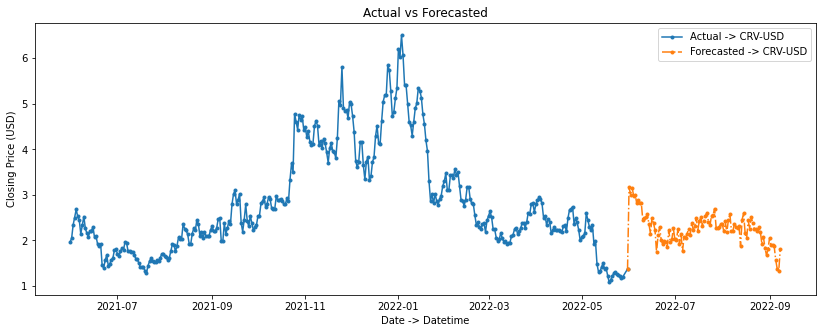

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (14, 5))
ax.plot(results.index, results['Actual'], marker = '.', linestyle = '-', label = "Actual -> CRV-USD")
ax.plot(results.index, results['Forecast'], marker = '.', linestyle = '-.', label = "Forecasted -> CRV-USD")
ax.set_title("Actual vs Forecasted")
ax.set_ylabel("Closing Price (USD)")
ax.set_xlabel("Date -> Datetime")
ax.legend()